In [1]:
from src.functions.compute_angular_profiles import compute_angular_profiles
from src.functions.langevin_gillespie import langevin_gillespie
import numpy as np
import math
import matplotlib.pyplot as plt
import time as t

In [2]:
# Step One: Initialize Parameters

# Set Seed for reproducibility
np.random.seed(42)

# Elastic Constants
kappa = 56  # pN.nm/rad^2
ktrap = 240  # pN.nm/rad^2

# Thermal Energy at room temperature
kBT = 4.14  # pN.nm

# Unknown Parameters
r = 19  # nm - distance from the rotational axis to the center of the sphere
a = 20  # nm - radius of a sphere (See https://en.wikipedia.org/wiki/Stokes_flow)

# Viscosity and drag terms for rotational friction
eta = 1e-9  # pN.s/nm^2
gammaB = 8 * math.pi * eta * math.pow(a, 3) + 6 * math.pi * eta * a * math.pow(r, 2)  # Rotational drag: spin + offset from axis

# Angles
th1 = 0

# Simulation Parameters
nSim = 500  # Number of simulations
dur = 120  # Steps per simulation
dt = 1e-6  # Step size (s)

pos = np.sqrt(kBT / (10 * kappa)) * np.random.randn(nSim) + th1  # Initial angles with small thermal fluctuations

method = "heun"

In [3]:
# Step Two: Langevin - Gillespie // Get Data
pos_store, state_store, theta_store = langevin_gillespie(nSim, dur, dt, pos, gammaB, kappa, kBT, method)

In [4]:
# Step 2a: Angular Profiles
profile, jump_pdf, profile_coarse, jump_pdf_coarse = compute_angular_profiles(dt, pos_store, state_store)

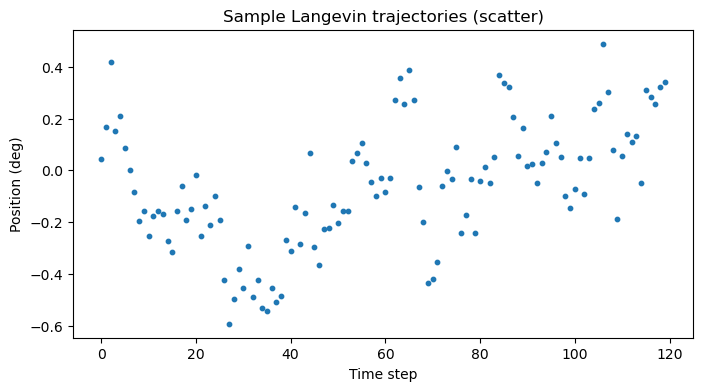

In [5]:
# Step Three: Visualize Data
plt.figure(figsize=(8, 4))
time = np.arange(pos_store.shape[0])  # time steps
for k in range(min(1, nSim)):
    plt.scatter(time, pos_store[:, k], s=10, alpha=1)
plt.xlabel("Time step")
plt.ylabel("Position (deg)")
plt.title("Sample Langevin trajectories (scatter)");

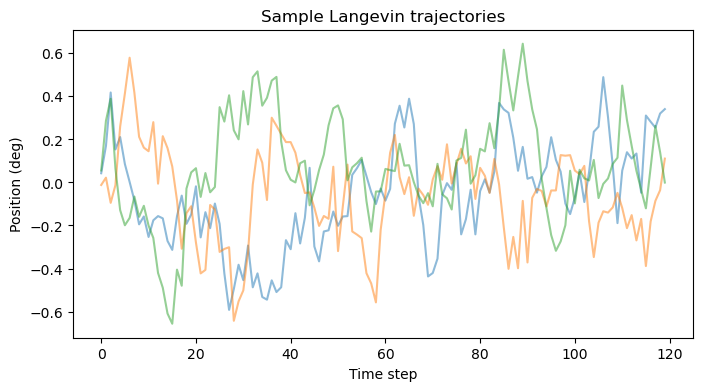

In [6]:
plt.figure(figsize=(8, 4))
for k in range(min(3, nSim)):
    plt.plot(pos_store[:, k], alpha=0.5)
plt.xlabel("Time step")
plt.ylabel("Position (deg)")
plt.title("Sample Langevin trajectories");

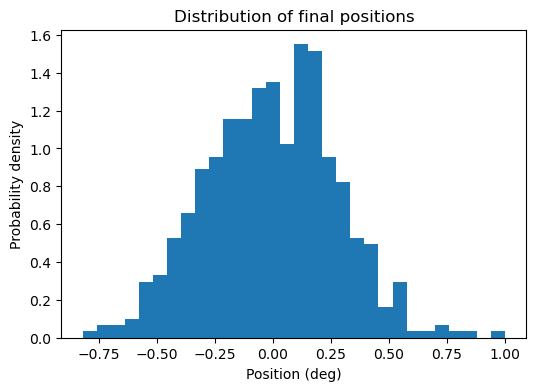

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(pos_store[-1, :], bins=30, density=True)
plt.xlabel("Position (deg)")
plt.ylabel("Probability density")
plt.title("Distribution of final positions");


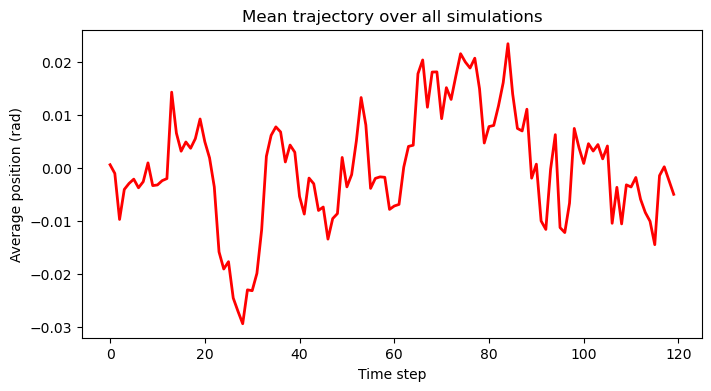

In [8]:
mean_pos = pos_store.mean(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(mean_pos, color="red", linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Average position (rad)")
plt.title("Mean trajectory over all simulations");

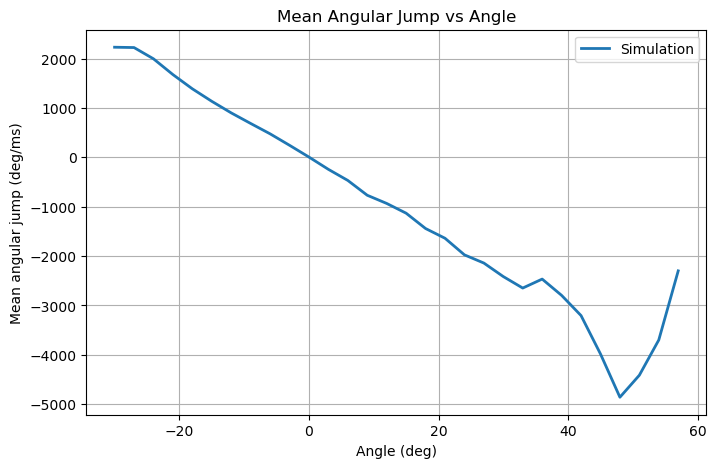

In [9]:
plt.figure(figsize=(8, 5))

# Use the coarse profile for smoother line
plt.plot(profile_coarse[:, 0], profile_coarse[:, 1], label="Simulation", linewidth=2)

plt.xlabel("Angle (deg)")
plt.ylabel("Mean angular jump (deg/ms)")
plt.title("Mean Angular Jump vs Angle")
plt.legend()
plt.grid(True)

<hr>
To compute 1,000,000 simulations, this takes ~150 seconds for LG (1 State) and another 100 for the angular profiles
After Analysis of LG, the worst case scenerio time compexity is O(nSim * dur)

This is why GPU acceleration will be important later in the project<br>
GPU acceleration will allow us to get as much throughput as possible<br>

In [58]:
# Test LG
nSimulations_test = 1_000_000
test_pos = np.sqrt(kBT / (10 * kappa)) * np.random.randn(nSimulations_test) + th1  # Initial angles with small thermal fluctuations
last = t.time()
a,b, _ =langevin_gillespie(nSimulations_test, dur, dt, test_pos, gammaB, kappa, kBT, method)
now = t.time()
print(f'Computing {langevin_gillespie.__name__} for {nSimulations_test} simulations took {now - last} seconds')

Computing langevin_gillespie for 1000000 simulations took 144.65237998962402 seconds


In [59]:
# Test Angular Profiles
last = t.time()
_, _, _, _ = compute_angular_profiles(dt, a, b)
now = t.time()
print(f'{compute_angular_profiles.__name__} for {nSimulations_test} simulations took {now - last} seconds')

compute_angular_profiles for 1000000 simulations took 117.93305587768555 seconds


<hr>
Differing angle views

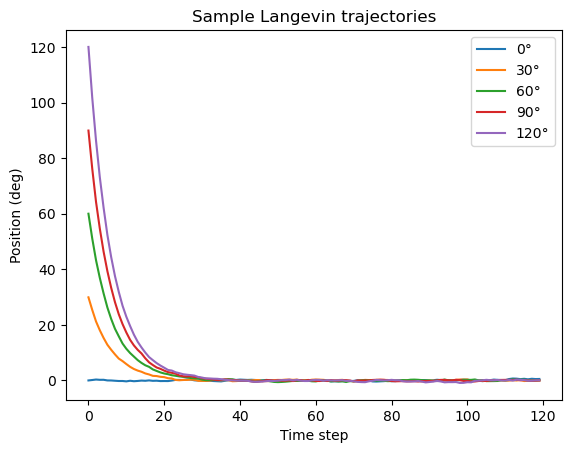

In [54]:
angle_sim_number = 1
for angle in range(0, 121, 30):
    pos = np.sqrt(kBT / (10 * kappa)) * np.random.randn(angle_sim_number) + angle
    pos_store, state_store, theta_store = langevin_gillespie(angle_sim_number, dur, dt, pos, gammaB, kappa, kBT, method)
    plt.plot(pos_store[:, 0], alpha=1, label = f"{angle}°")

plt.xlabel("Time step")
plt.ylabel("Position (deg)")
plt.title("Sample Langevin trajectories");
plt.legend();